# Домашнее задание №5.
Основы машинн
ого обучения. В.Журавлев  
Группа ML-11. __Студент - Усцов Артем Алексеевич__

- Участникам предоставлен набор данных объявлений о продаже недвижимости в некотором волшебном городе N.  
- __Задача__ - предсказать цену недвижимости по содержанию объявления

In [126]:
# Для функционирования watermark - раскомментируйте строку ниже, либо установите библиотеку в консоли вручную
# !pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [127]:
%watermark -v -m -p numpy,scipy,matplotlib,pandas,sklearn,seaborn,tqdm -g

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.28.0

numpy     : 1.20.1
scipy     : 1.6.2
matplotlib: 3.4.3
pandas    : 1.2.2
sklearn   : 0.0
seaborn   : 0.11.2
tqdm      : 4.62.3

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-88-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: a879a139335d0fbac0fe9d8281daa9462eaf785a



In [128]:
!lscpu

Архитектура:                     x86_64
CPU op-mode(s):                  32-bit, 64-bit
Порядок байт:                    Little Endian
Address sizes:                   39 bits physical, 48 bits virtual
CPU(s):                          8
On-line CPU(s) list:             0-7
Потоков на ядро:                 2
Ядер на сокет:                   4
Сокетов:                         1
NUMA node(s):                    1
ID прроизводителя:               GenuineIntel
Семейство ЦПУ:                   6
Модель:                          142
Имя модели:                      Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz
Степпинг:                        10
CPU МГц:                         2831.579
CPU max MHz:                     3400,0000
CPU min MHz:                     400,0000
BogoMIPS:                        3600.00
Виртуализация:                   VT-x
L1d cache:                       128 KiB
L1i cache:                       128 KiB
L2 cache:                        1 MiB
L3 cache:                      

## Service function declaration

In [129]:
# Future Python versions compatibility
from __future__ import division

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

# System libraries
import os

# Object libraries
import pandas as pd
import numpy as np
import seaborn as sns


# ML libraries
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, roc_curve, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Data Transformers
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer

# Visualize libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Colors map
colors_list = list(colors._colors_full_map.values())
%matplotlib inline

# Time libraries
from tqdm import tqdm_notebook
import time

# ML clusterisation
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture

In [130]:
# Missing values detection function
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
                                mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                                '% of Total Values', ascending=False).round(2)

    print("Your selected dataframe has "  + str(df.shape[0]) + " objects with " + str(df.shape[1]) 
                                          + " features.\n"
                             "There are " + str(mis_val_table_ren_columns.shape[0]) +
                             " features that have missing values.")

    return mis_val_table_ren_columns

In [131]:
# Gradient Boosting Machine libraries

# !pip install catboost
import catboost

from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from catboost import Pool

# Optimizers librairy
# !pip install hyperopt
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Отмечу особенность, GPU на локальном ноутбуке слабоват + catboost не заточен под него.  
Оттого вычисления на видеокарте отложены в сторону(

## Data Processing

### Overview

In [ ]:
# Загружаем данные сенсоров
df = pd.read_csv("https://raw.githubusercontent.com/Totenkaf/ML_Homeworks/main/HW_4/data/sign_database.csv")
df_test = pd.read_csv('https://raw.githubusercontent.com/Totenkaf/ML_Homeworks/main/HW_4/data/sign_classes.csv')

In [200]:
df = pd.read_csv('data/Train.csv')
df_test = pd.read_csv('data/Test.csv')

In [201]:
df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,560,NaN,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,4510000
1,1,2011-1,667,NaN,10,50,2,1,25.0,NaN,...,0,0,0,0,0,0,0,0,0,13231000
2,2,2011-1,90,0.0,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,2008000
3,3,2011-1,94,1.0,3,62,3,1,30.0,NaN,...,0,0,0,0,0,0,0,0,0,12680000
4,4,2011-1,232,0.0,3,60,3,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,3335000


In [202]:
df_test.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,2012-3,459,NaN,1,60,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,2012-3,344,1.0,10,52,2,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,100002,2012-3,585,0.0,4,54,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100003,2012-3,494,NaN,2,52,2,1,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,2012-3,622,1.0,9,60,3,1,15.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   date        100000 non-null  object 
 2   street_id   100000 non-null  int64  
 3   build_tech  70265 non-null   float64
 4   floor       100000 non-null  int64  
 5   area        100000 non-null  int64  
 6   rooms       100000 non-null  int64  
 7   balcon      100000 non-null  int64  
 8   metro_dist  95104 non-null   float64
 9   g_lift      70008 non-null   float64
 10  n_photos    100000 non-null  int64  
 11  kw1         100000 non-null  int64  
 12  kw2         100000 non-null  int64  
 13  kw3         100000 non-null  int64  
 14  kw4         100000 non-null  int64  
 15  kw5         100000 non-null  int64  
 16  kw6         100000 non-null  int64  
 17  kw7         100000 non-null  int64  
 18  kw8         100000 non-null  int64  
 19  kw9

In [204]:
df.head().T

,0,1,2,3,4
id,0,1,2,3,4
date,2011-1,2011-1,2011-1,2011-1,2011-1
street_id,560,667,90,94,232
build_tech,NaN,NaN,0.0,1.0,0.0
floor,2,10,1,3,3
area,59,50,48,62,60
rooms,3,2,2,3,3
balcon,0,1,0,1,0
metro_dist,30.0,25.0,25.0,30.0,25.0
g_lift,1.0,NaN,0.0,NaN,NaN


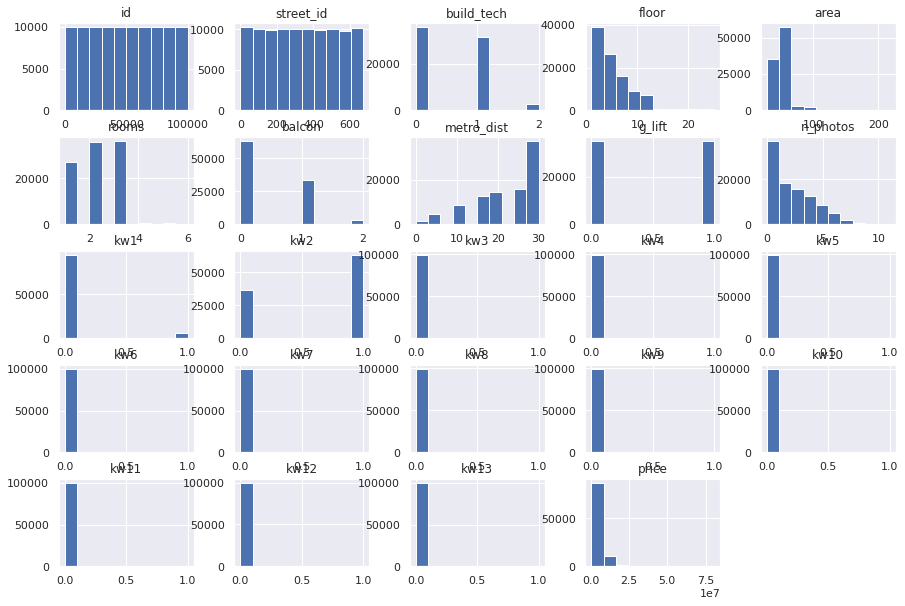

In [205]:
# Посмотрим на общее распределение данных
df.hist(figsize=(15, 10))
plt.show()

In [206]:
# Непонятный признак g_lift.
df[{'price', 'g_lift'}].groupby(['g_lift']).mean()

,price
g_lift,
0.0,5.131845e+06
1.0,5.154801e+06


Хочется сказать, что наличие лифта не повышает стоимость жилплощади, что чисто по житейскому опыту совсем не так.

<AxesSubplot:>

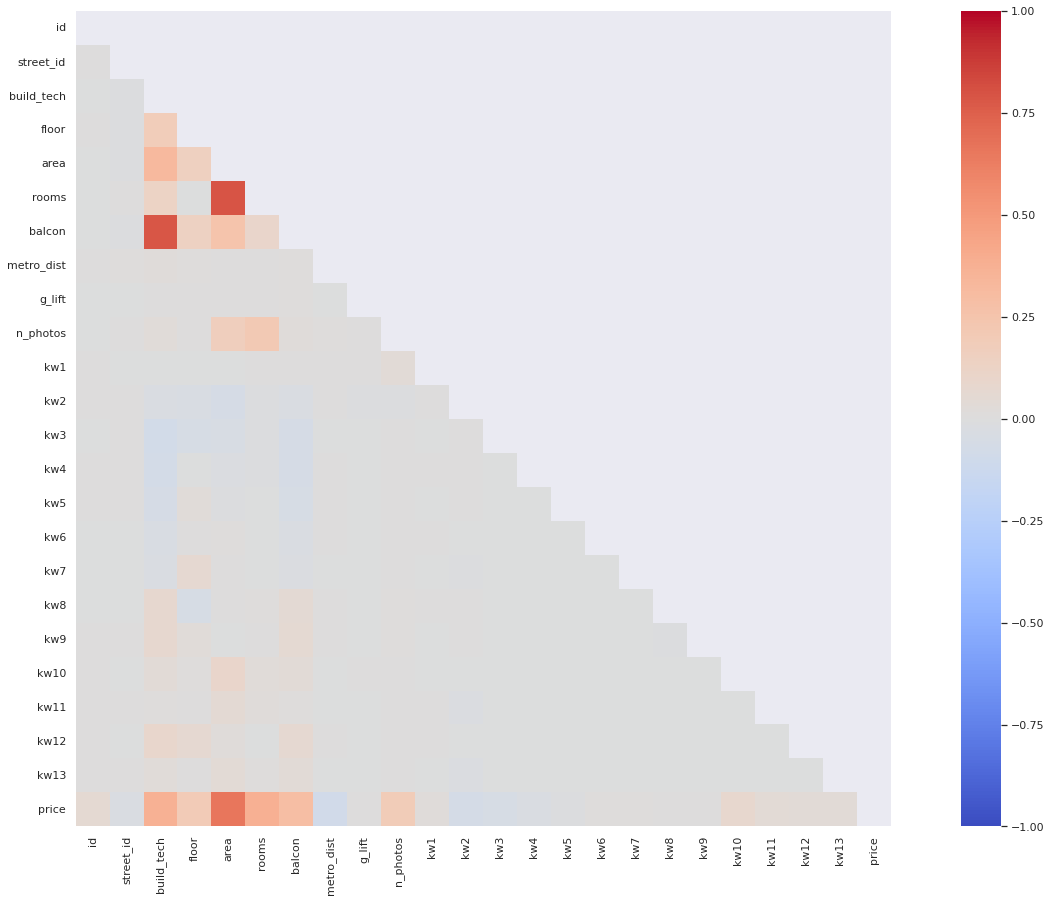

In [207]:
# А также посмотрим, как фичи кореллируют с ценой
sns.set(rc = {'figure.figsize':(25,15)})
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), fmt='.1g', cmap= 'coolwarm', square=True, mask=matrix, vmin=-1, vmax=1, center= 0)

Как и ожидалось, сильнейшая связь цены с площадью, количеством комнат, а также расстоянием до метро.
Также отметим, что наличие лифта и вправду не коррелирует с ценой квартиры.  

Принимаю решение убрать признак полностью из модели.

In [208]:
# Удалим неинформативные столбецы
df.drop(['id', 'g_lift'], axis=1, inplace=True)
df_test.drop(['id', 'g_lift'], axis=1, inplace=True)
df.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-1,560,NaN,2,59,3,0,30.0,5,0,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,1,0,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-1,90,0.0,1,48,2,0,25.0,1,0,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-1,94,1.0,3,62,3,1,30.0,3,0,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-1,232,0.0,3,60,3,0,25.0,3,0,...,0,0,0,0,0,0,0,0,0,3335000


Посмотрим на признаки наличия ключевых слов в объявлении о продаже - kw1_kw13

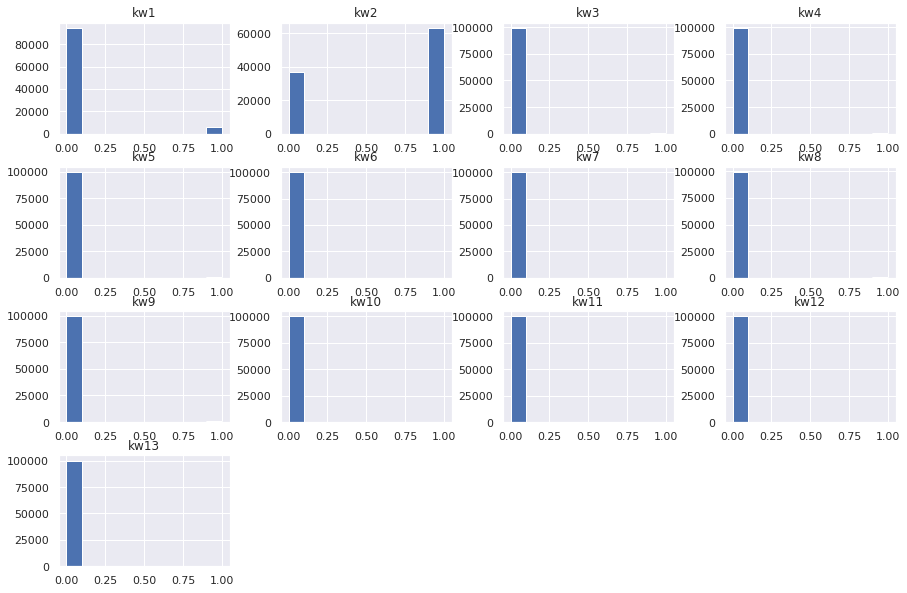

In [209]:
df.iloc[:, 9:22].hist(figsize=(15, 10))
plt.show()

Как видно, kw3-kw 13 очень разряжены. Пока оставим фичи в датасете

In [210]:
missing_values_table(df)

Your selected dataframe has 100000 objects with 23 features.
There are 2 features that have missing values.


,Missing Values,% of Total Values
build_tech,29735,29.74
metro_dist,4896,4.90


Как видно, существует большое количество пропусков в 2 фичах. Удаление здесь не поможет, требуется замена значений

In [211]:
print(f"1) build_tech unique values: {pd.unique(df['build_tech'])}")
print(f"2) metro_dist unique values: {pd.unique(df['metro_dist'])}")

1) build_tech unique values: [nan  0.  1.  2.]
2) metro_dist unique values: [30. 25. 20. 15. 10. nan  0.  5.]


Медианное значение возможно поставить только для metro_dist. Все остальные фичи - категориальные

In [212]:
# Приведем дату к нужному формату
df["date"] = pd.to_datetime(df["date"])
df_test["date"] = pd.to_datetime(df["date"])

In [213]:
df.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-01-01,560,NaN,2,59,3,0,30.0,5,0,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-01-01,667,NaN,10,50,2,1,25.0,1,0,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-01-01,90,0.0,1,48,2,0,25.0,1,0,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-01-01,94,1.0,3,62,3,1,30.0,3,0,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-01-01,232,0.0,3,60,3,0,25.0,3,0,...,0,0,0,0,0,0,0,0,0,3335000


### Feature Generation

Предположим, что с течением времени цена на квартиры меняется в связи с инфляцией и прочими факторами. Оттого, чем раньше была продана квартира, тем меньше ее целевой вес в модели.

In [214]:
# Для train выборки
df['year'] = pd.DatetimeIndex(df["date"]).year - 2011
df['mohth_from_begin'] = df["year"] * 12 + pd.DatetimeIndex(df["date"]).month

# Для test выборки
df_test['year'] = pd.DatetimeIndex(df_test.date).year - 2011
df_test['mohth_from_begin'] = df_test["year"] * 12 + pd.DatetimeIndex(df_test["date"]).month


# Сразу же удалим из датасета излишние фичи
del df['date']
del df['year']

del df_test['date']
del df_test['year']

In [215]:
df.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,mohth_from_begin
0,560,NaN,2,59,3,0,30.0,5,0,1,...,0,0,0,0,0,0,0,0,4510000,1
1,667,NaN,10,50,2,1,25.0,1,0,1,...,0,0,0,0,0,0,0,0,13231000,1
2,90,0.0,1,48,2,0,25.0,1,0,1,...,0,0,0,0,0,0,0,0,2008000,1
3,94,1.0,3,62,3,1,30.0,3,0,1,...,0,0,0,0,0,0,0,0,12680000,1
4,232,0.0,3,60,3,0,25.0,3,0,1,...,0,0,0,0,0,0,0,0,3335000,1


In [216]:
df_test.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,mohth_from_begin
0,459,NaN,1,60,3,1,30.0,4,0,0,...,0,0,0,0,0,0,0,0,0,1
1,344,1.0,10,52,2,1,NaN,4,0,0,...,0,0,0,0,0,0,0,0,0,1
2,585,0.0,4,54,3,0,30.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,494,NaN,2,52,2,1,25.0,3,0,1,...,0,0,0,0,0,0,0,0,0,1
4,622,1.0,9,60,3,1,15.0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


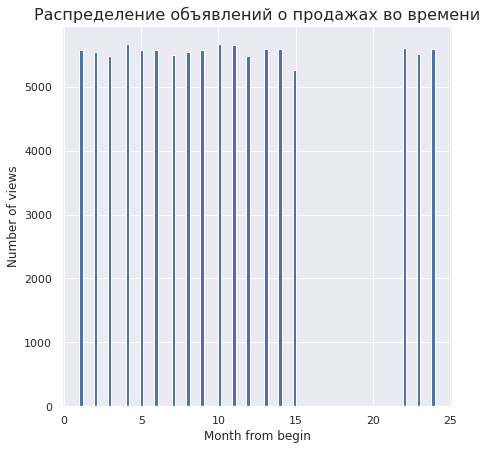

In [217]:
plt.figure(figsize=(7,7))
plt.hist(df["mohth_from_begin"].values, bins=100)
plt.title("Распределение объявлений о продажах во времени", fontsize=16)
plt.xlabel("Month from begin")
plt.ylabel("Number of views")
None

Очередная особенность. Отсутствуют продажи спустя год от начала объявлений.

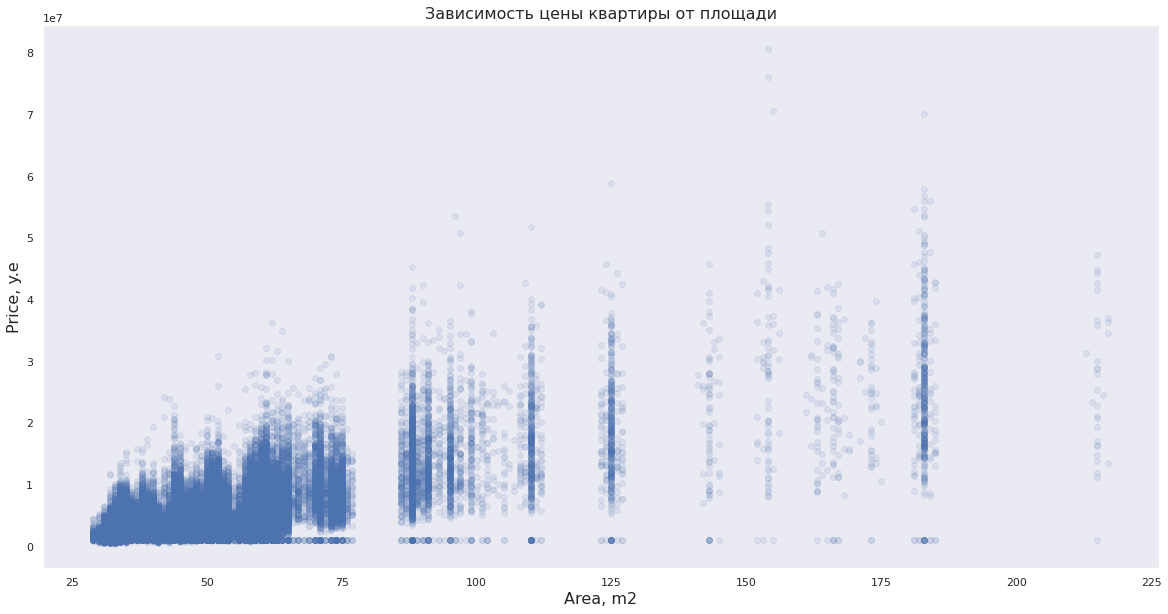

In [218]:
# Предполагаю, что цена в первую очередь зависит от площади квартиры.
# Гипотеза подтверждается визуально на heatmap
# Проверим
plt.figure(figsize=(20, 10))
plt.scatter(df["area"].values, df["price"].values,alpha=0.1)
plt.title("Зависимость цены квартиры от площади", fontsize=16)
plt.xlabel("Area, m2", fontsize=16)
plt.ylabel("Price, y.e", fontsize=16)
plt.grid()

plt.show()

Да, похоже на линейную зависимость. В глаза сразу бросается особенность. Одинаковая цена за разные площади, что выглядит необычно

In [219]:
df['price'].value_counts()

1000000     4079
2935000       36
2802000       35
3200000       34
4001000       31
            ... 
9709000        1
15233000       1
19058000       1
10561000       1
9845000        1
Name: price, Length: 15007, dtype: int64

Особенность налицо, похоже что-то фиктивное. Уберу из датасета, чтобы не смещать предсказание

In [220]:
df = df.iloc[df['price'].values != 1000000, :]

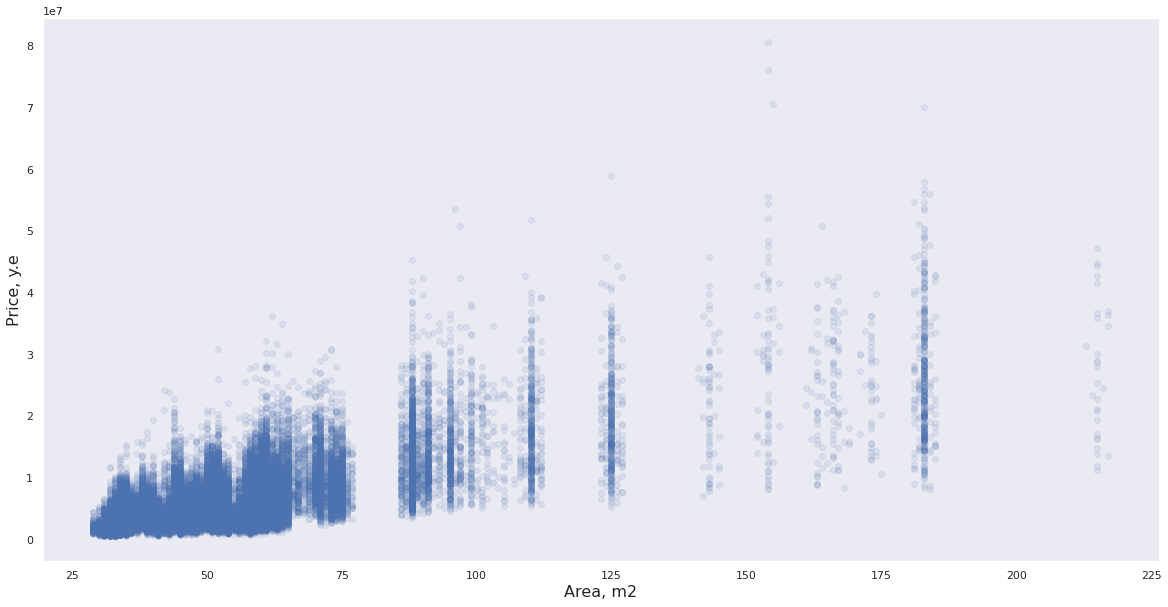

In [221]:
# Проверим теперь
plt.figure(figsize=(20, 10))
plt.scatter(df["area"].values, df["price"].values,alpha=0.1)
plt.xlabel("Area, m2", fontsize=16)
plt.ylabel("Price, y.e", fontsize=16)
plt.grid()

plt.show()

Много лучше, теперь все чисто

Так как существует сильная зависимость между ценой и площадью квартиры, попробуем синтезировать искуственный признак - среднюю цену за квадратный метр квартиры

In [222]:
df['price_per_m2'] = df["price"] / df["area"]
df.reset_index(inplace=True) # учтем смещение id в результате удаления квартир за 1 000 000
del df['index']
df.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,mohth_from_begin,price_per_m2
0,560,NaN,2,59,3,0,30.0,5,0,1,...,0,0,0,0,0,0,0,4510000,1,76440.677966
1,667,NaN,10,50,2,1,25.0,1,0,1,...,0,0,0,0,0,0,0,13231000,1,264620.000000
2,90,0.0,1,48,2,0,25.0,1,0,1,...,0,0,0,0,0,0,0,2008000,1,41833.333333
3,94,1.0,3,62,3,1,30.0,3,0,1,...,0,0,0,0,0,0,0,12680000,1,204516.129032
4,232,0.0,3,60,3,0,25.0,3,0,1,...,0,0,0,0,0,0,0,3335000,1,55583.333333


### Fill in the blanks

Пропуски: build_tech, metro_dist.  
Проставим веса наблюдениями по принципу:есть пропуск - вес меньше.

Считаю веса наблюдений. Редкие более ценны чем частые

In [223]:
# Заполним все пропуски в датасете на очень маленькое число
df.fillna(value=-9999, inplace=True)
df_test.fillna(value=-9999, inplace=True)

# у квартир с одинаковой ценой вес меньше
df['weights_unique'] = 0  
counts = df["price"].value_counts().values
values = df["price"].value_counts().index.values
for i in range(values.shape[0]):
    df.weights_unique[df["price"].values == values[i]] = 1 / np.cbrt(counts[i])  # веса наблюдений

    
# у квартир с пропусками вес меньше
df['weights_miss'] = 1  
df.weights_miss[df["metro_dist"].values == -9999] = df['weights_miss'][df["metro_dist"].values == -9999] * 0.7 # предсказывается средне
df.weights_miss[df["build_tech"].values == -9999] = df['weights_miss'][df["build_tech"].values == -9999] * 0.8  # предсказывается хорошо

# более поздние наблюдения имеют больший вес
df['month_weights'] = np.cbrt(df["mohth_from_begin"].values)  


df['weights'] = df['weights_unique'] * df['weights_miss'] + df['month_weights']

del df['weights_miss']
del df['month_weights']
del df['weights_unique']
df.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw8,kw9,kw10,kw11,kw12,kw13,price,mohth_from_begin,price_per_m2,weights
0,560,-9999.0,2,59,3,0,30.0,5,0,1,...,0,0,0,0,0,0,4510000,1,76440.677966,1.340232
1,667,-9999.0,10,50,2,1,25.0,1,0,1,...,0,0,0,0,0,0,13231000,1,264620.000000,1.800000
2,90,0.0,1,48,2,0,25.0,1,0,1,...,0,0,0,0,0,0,2008000,1,41833.333333,1.405480
3,94,1.0,3,62,3,1,30.0,3,0,1,...,0,0,0,0,0,0,12680000,1,204516.129032,2.000000
4,232,0.0,3,60,3,0,25.0,3,0,1,...,0,0,0,0,0,0,3335000,1,55583.333333,1.425290


In [224]:
check = df[{'metro_dist', 'price'}].groupby(['metro_dist']).mean() # скорее всего просто разбросаны. Имеет смысл заполнять моделью 
check.head(20)

,price
metro_dist,
-9999.0,5.283112e+06
0.0,6.044868e+06
5.0,5.926236e+06
10.0,5.915242e+06
15.0,5.774506e+06
20.0,5.584376e+06
25.0,5.165248e+06
30.0,4.880374e+06


Заполним пропуски в build_tech. Данные категориальные, оттого используем мультиклассификационные деревья  
Вначале проведем валидацию, посмотрим на ошибку.

In [225]:
# На валидацию берем как раз те данные, что были после 20 месяца
df_train = df[(df["mohth_from_begin"].values < 20) * (df["build_tech"].values != -9999)]
df_valid = df[(df["mohth_from_begin"].values > 20) * (df["build_tech"].values != -9999)]

features = ['street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']


train_pool = Pool(data=df_train[features], label=df_train.build_tech.values, 
                  cat_features=cat_features, weight = df_train.weights.values)
valid_pool = Pool(df_valid[features], label=df_valid.build_tech.values, 
                  cat_features=cat_features)

build_model = CatBoostClassifier(random_state=42)
build_model.fit(train_pool, eval_set=valid_pool, verbose = False, plot=True)

pred_train = build_model.predict(df_train[features])
pred_valid = build_model.predict(df_valid[features])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [226]:
print("train: \n", classification_report(pred_train, df_train.build_tech.values))
print("valid: \n", classification_report(pred_valid, df_valid.build_tech.values))

train: 
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     29773
         1.0       0.92      0.97      0.94     24046
         2.0       0.97      0.97      0.97      2234

    accuracy                           0.95     56053
   macro avg       0.95      0.96      0.96     56053
weighted avg       0.95      0.95      0.95     56053

valid: 
               precision    recall  f1-score   support

         0.0       0.97      0.93      0.94      6068
         1.0       0.91      0.96      0.93      4808
         2.0       0.95      0.96      0.96       456

    accuracy                           0.94     11332
   macro avg       0.94      0.95      0.94     11332
weighted avg       0.94      0.94      0.94     11332



Будем считать качество на дефолтных деревьях удовлетворительным (за неимением другого).   
В качестве оптимизации можно попробовать подобрать гиперпараметры, однако KIS никто не отменял

In [227]:
# Теперь проведем подстановку фич на всем датасете
mask = df["build_tech"].values != -9999
features = ['street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

train_pool = Pool(data=df[features][mask], label=df.build_tech[mask].values, 
                  cat_features=cat_features, weight = df.weights[mask].values)

build_model = CatBoostClassifier(random_state=42)
build_model.fit(train_pool, verbose = False, plot=True)

pred_train = build_model.predict(train_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [228]:
df["build_tech"][df["build_tech"].values == -9999] =\
                build_model.predict(df[df["build_tech"].values == -9999][features].values).reshape(-1)
df_test["build_tech"][df_test["build_tech"].values == -9999] =\
                build_model.predict(df_test[df_test["build_tech"].values == -9999][features].values).reshape(-1)

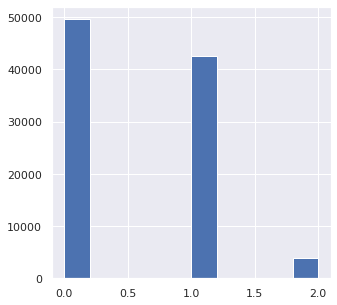

In [229]:
# Посмотрим на общее распределение данных
df["build_tech"].hist(figsize=(5, 5))
plt.show()

Заполним пропуски в metro_dist. Данные вещественные, оттого используем регрессионные деревья  
По аналогии с мультиклассификацией, вначале проведем валидацию. Разбиение на выборку - то же.

In [230]:
# На валидацию берем как раз те данные, что были после 20 месяца
df_train = df[(df["mohth_from_begin"].values < 20) * (df["metro_dist"].values != -9999)]
df_valid = df[(df["mohth_from_begin"].values > 20) * (df["metro_dist"].values != -9999)]

features = ['street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']


train_pool = Pool(data=df_train[features], label=df_train["metro_dist"], 
                  cat_features=cat_features, weight=df_train["weights"].values)
valid_pool = Pool(data=df_valid[features], label=df_valid["metro_dist"], 
                  cat_features=cat_features)

metro_model = CatBoostRegressor(loss_function='MAE', eval_metric='MAE', 
                random_state=42, n_estimators=3000,
)
metro_model.fit(train_pool, eval_set=valid_pool, verbose = False, plot=True)

pred_train = metro_model.predict(df_train[features])
pred_valid = metro_model.predict(df_valid[features])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [231]:
print("train: \n", mean_absolute_error(pred_train, df_train.metro_dist.values))
print("valid: \n", mean_absolute_error(pred_valid, df_valid.metro_dist.values))

train: 
 5.057363222371981
valid: 
 5.270838167931126


MAE в 5% будем считать приемлемой, как инженерную погрешность

In [232]:
# Замена значений во всей выборке
mask = df.metro_dist.values != -9999
features = ['street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

train_pool = Pool(data=df[features][mask], label=df["metro_dist"][mask], 
                  cat_features=cat_features, weight = df["weights"][mask].values)

metro_model = CatBoostRegressor(loss_function='MAE', eval_metric='MAE', 
                random_state=42, n_estimators=3000)
metro_model.fit(train_pool, verbose = False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [233]:
df["metro_dist"][df["metro_dist"].values == -9999] =\
                                metro_model.predict(df[df["metro_dist"].values == -9999][features])
df_test["metro_dist"][df_test["metro_dist"] == -9999] =\
                                metro_model.predict(df_test[df_test["metro_dist"].values == -9999][features])

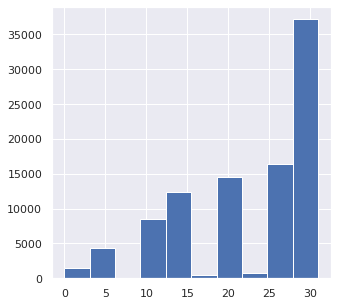

In [234]:
# Посмотрим на общее распределение данных
df["metro_dist"].hist(figsize=(5, 5))
plt.show()

### Time series impact in price

Посмотрим, как влияет временная компонента на распределение цен. Нет ли выбросов

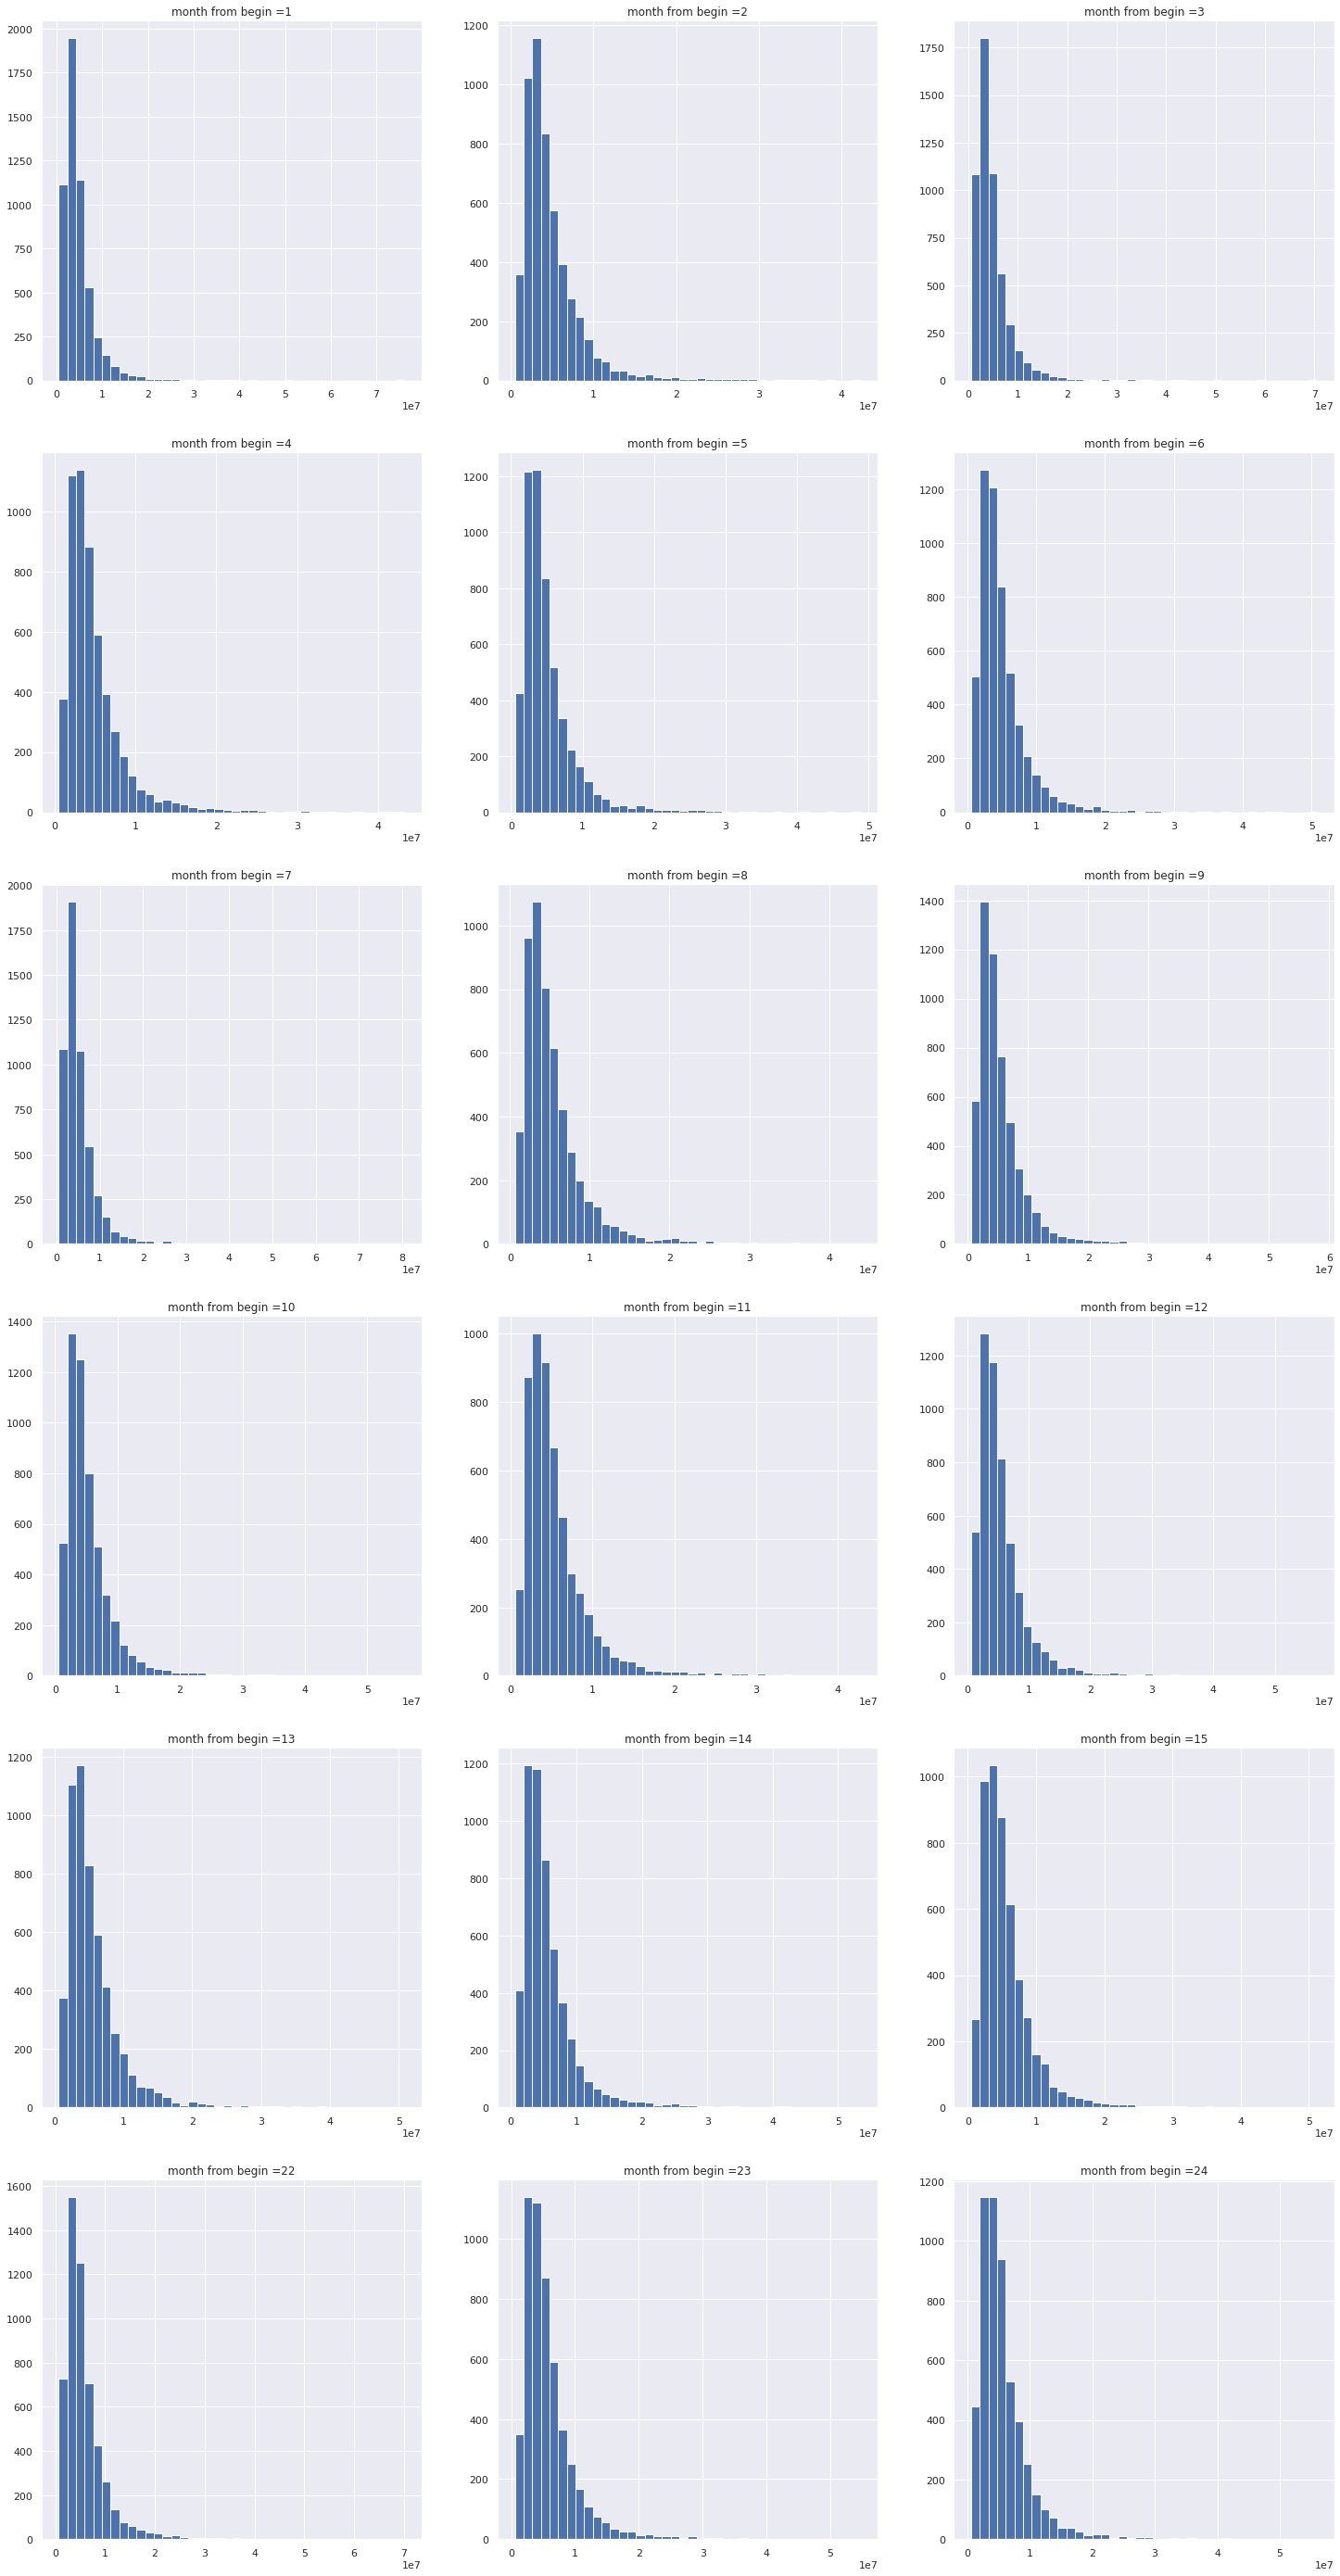

In [235]:
y = df["mohth_from_begin"].values
df['normal_price_month'] = 0.0

for i in np.unique(y):
    df["normal_price_month"][y == i] = df["price"][y == i].values.reshape(-1, 1).reshape(-1)

fig, ax = plt.subplots(6, 3, figsize=(25,50))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df["normal_price_month"][y == month].values, bins=40)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

Как видно, данные распределяются ненормально. Попробуем применить преобразования Бокса-Кокса для нормализации.  
Удобнее отслеживать пороговые значения

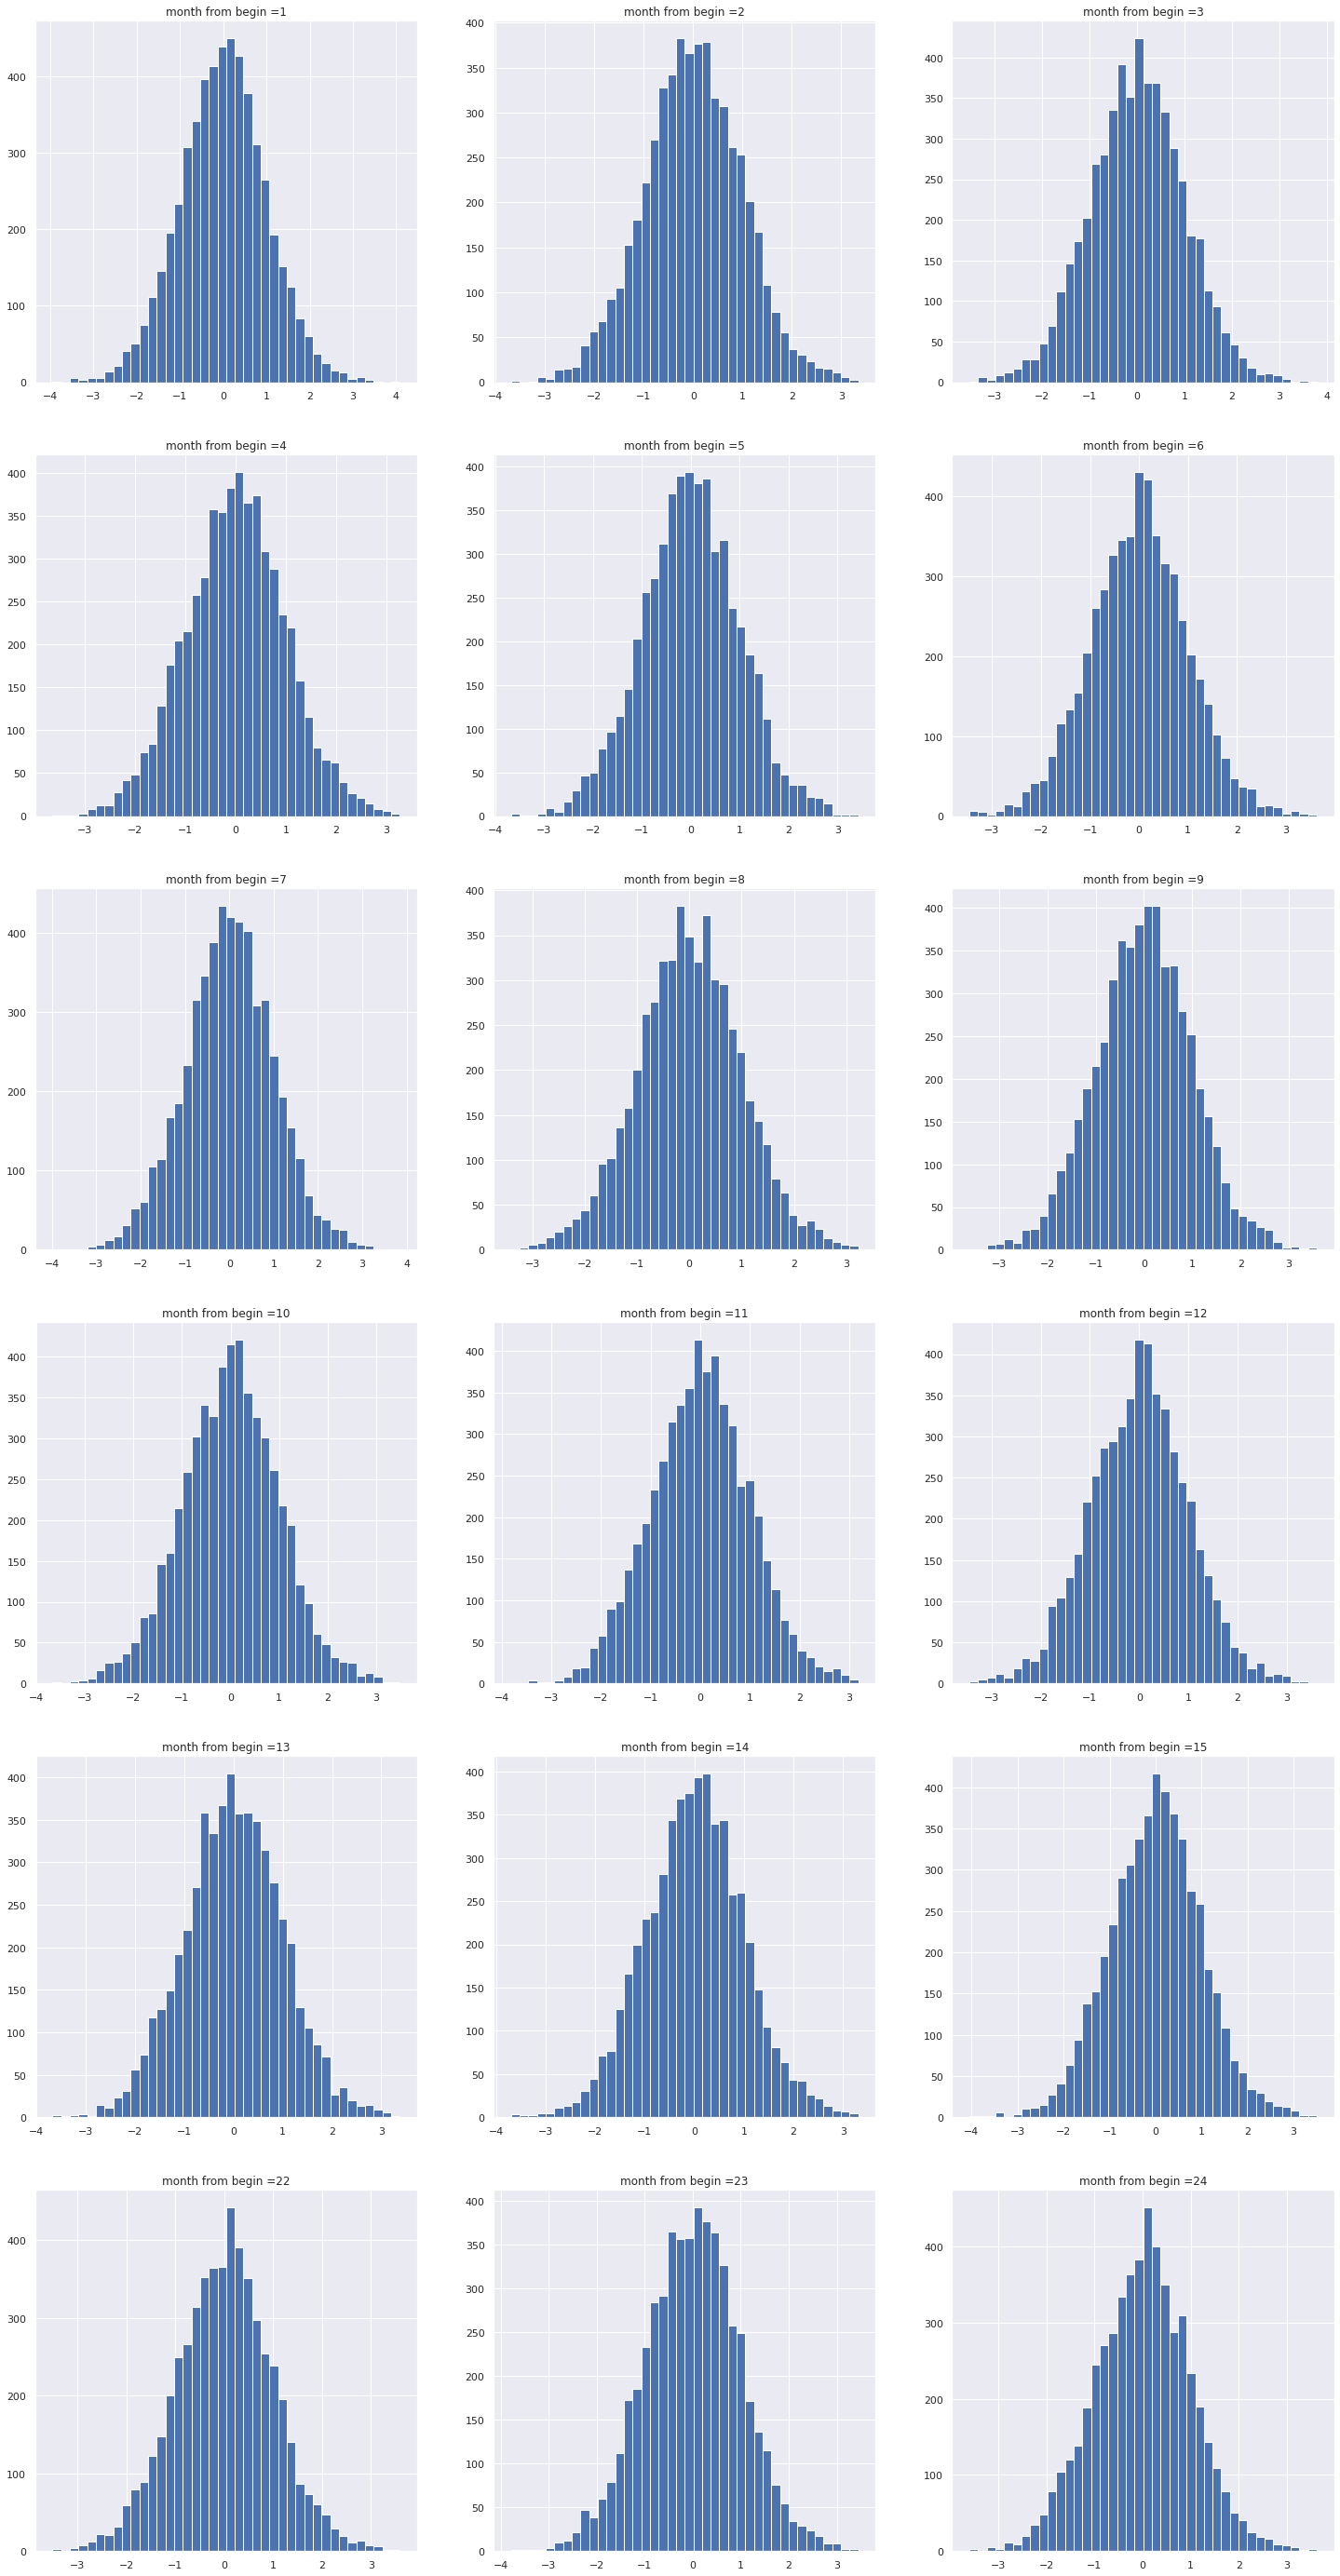

In [236]:
PW_array = []
y = df["mohth_from_begin"].values
df['normal_price_month'] = 0.0

for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df["price"][y == i].values.reshape(-1, 1))
    df["normal_price_month"][y == i] = PW.transform(df["price"][y == i].values.reshape(-1, 1)).reshape(-1)
    PW_array.append(PW)
    
fig, ax = plt.subplots(6, 3, figsize=(25,50))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df["normal_price_month"][y == month].values, bins=40)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

Картина обычная, аномалий в течение времени не обнаружилось

Теперь посмотрим, как обстоят дела со стоимостью квартиры в зависимости от улицы

In [237]:
PW_stree_array = []
y = df["street_id"].values
df['normal_price_street'] = 0.0

for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df["price"][y == i].values.reshape(-1, 1))
    df["normal_price_street"][y == i] = PW.transform(df["price"][y == i].values.reshape(-1, 1)).reshape(-1)
    PW_stree_array.append(PW)

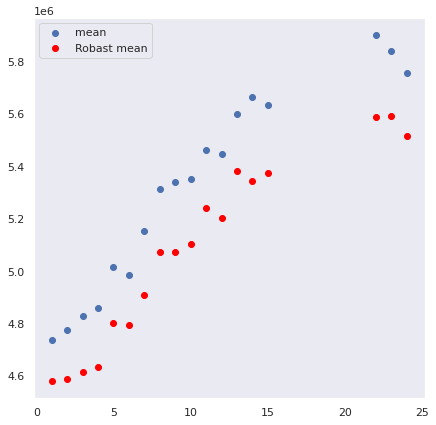

In [238]:
# Обычная оценка средней цены
mean_price = df[['price', 'mohth_from_begin']].groupby(['mohth_from_begin']).mean()

# вклад в стоимость, нет пропусков и уникальное значение стоимости - большой вклад
df['weight_price'] = df["price"] * df["weights"]

# Выберем только квартиры с ценами в пределах -2-2 стандартных отклонений по месяцам
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2) 
# Выберем только квартиры с ценами в пределах -3-3 стандартных отклонений по улицам 
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3)

mask = mask1 * mask2
# Посмотрим на более устойчивую к маленьким измнениям статистику - среднюю цену
robast_mean_price = df[['weight_price', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum() /\
                    df[['weights', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum().values

plt.figure(figsize=(7,7))
plt.scatter(mean_price.index, mean_price.values, label = "mean")
plt.scatter(robast_mean_price.index, robast_mean_price.values, label = "Robast mean", color="red")
plt.grid()
plt.legend()
plt.show()

Хорошая линейная зависимость. Можно поробовать решить задачу линейной регрессии, и синтезировать еще один признак в модель

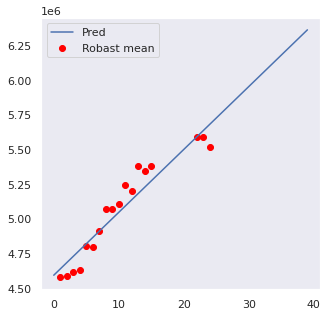

In [239]:
train = robast_mean_price
linear_model = SVR(kernel='poly', degree=1, C=1e5).fit(X = train.index.values.reshape(-1, 1), y = train.values)
pred = linear_model.predict(X = np.arange(0, 40).reshape(-1, 1))

plt.figure(figsize=(5,5))
plt.plot(np.arange(0, 40).reshape(-1, 1), pred, label = "Pred")
plt.scatter(robast_mean_price.index, robast_mean_price.values, label = "Robast mean", color="red")
plt.grid()
plt.legend()
plt.show()

Вычисляю коэффицент стоимости от месяца по модели

In [240]:
time_24 = linear_model.predict([[24]])

# Прогноз средней цены
df['pred_mean'] = linear_model.predict(df["mohth_from_begin"].values.reshape(-1, 1))

# Коэффициент стоимости от времени
df['model_time_coef'] = df["pred_mean"] / time_24

# Цена с поправкой на время
df['model_price_without_time'] = df["price"] / df["model_time_coef"]

# Прогноз средней цены для теста
df_test['model_pred_mean'] = linear_model.predict(df_test["mohth_from_begin"].values.reshape(-1, 1))
# Опорным берется последний месяц
df_test['model_time_coef'] = df_test["model_pred_mean"] / time_24

Стоимость квадратного метра в зависимости от даты и улицы

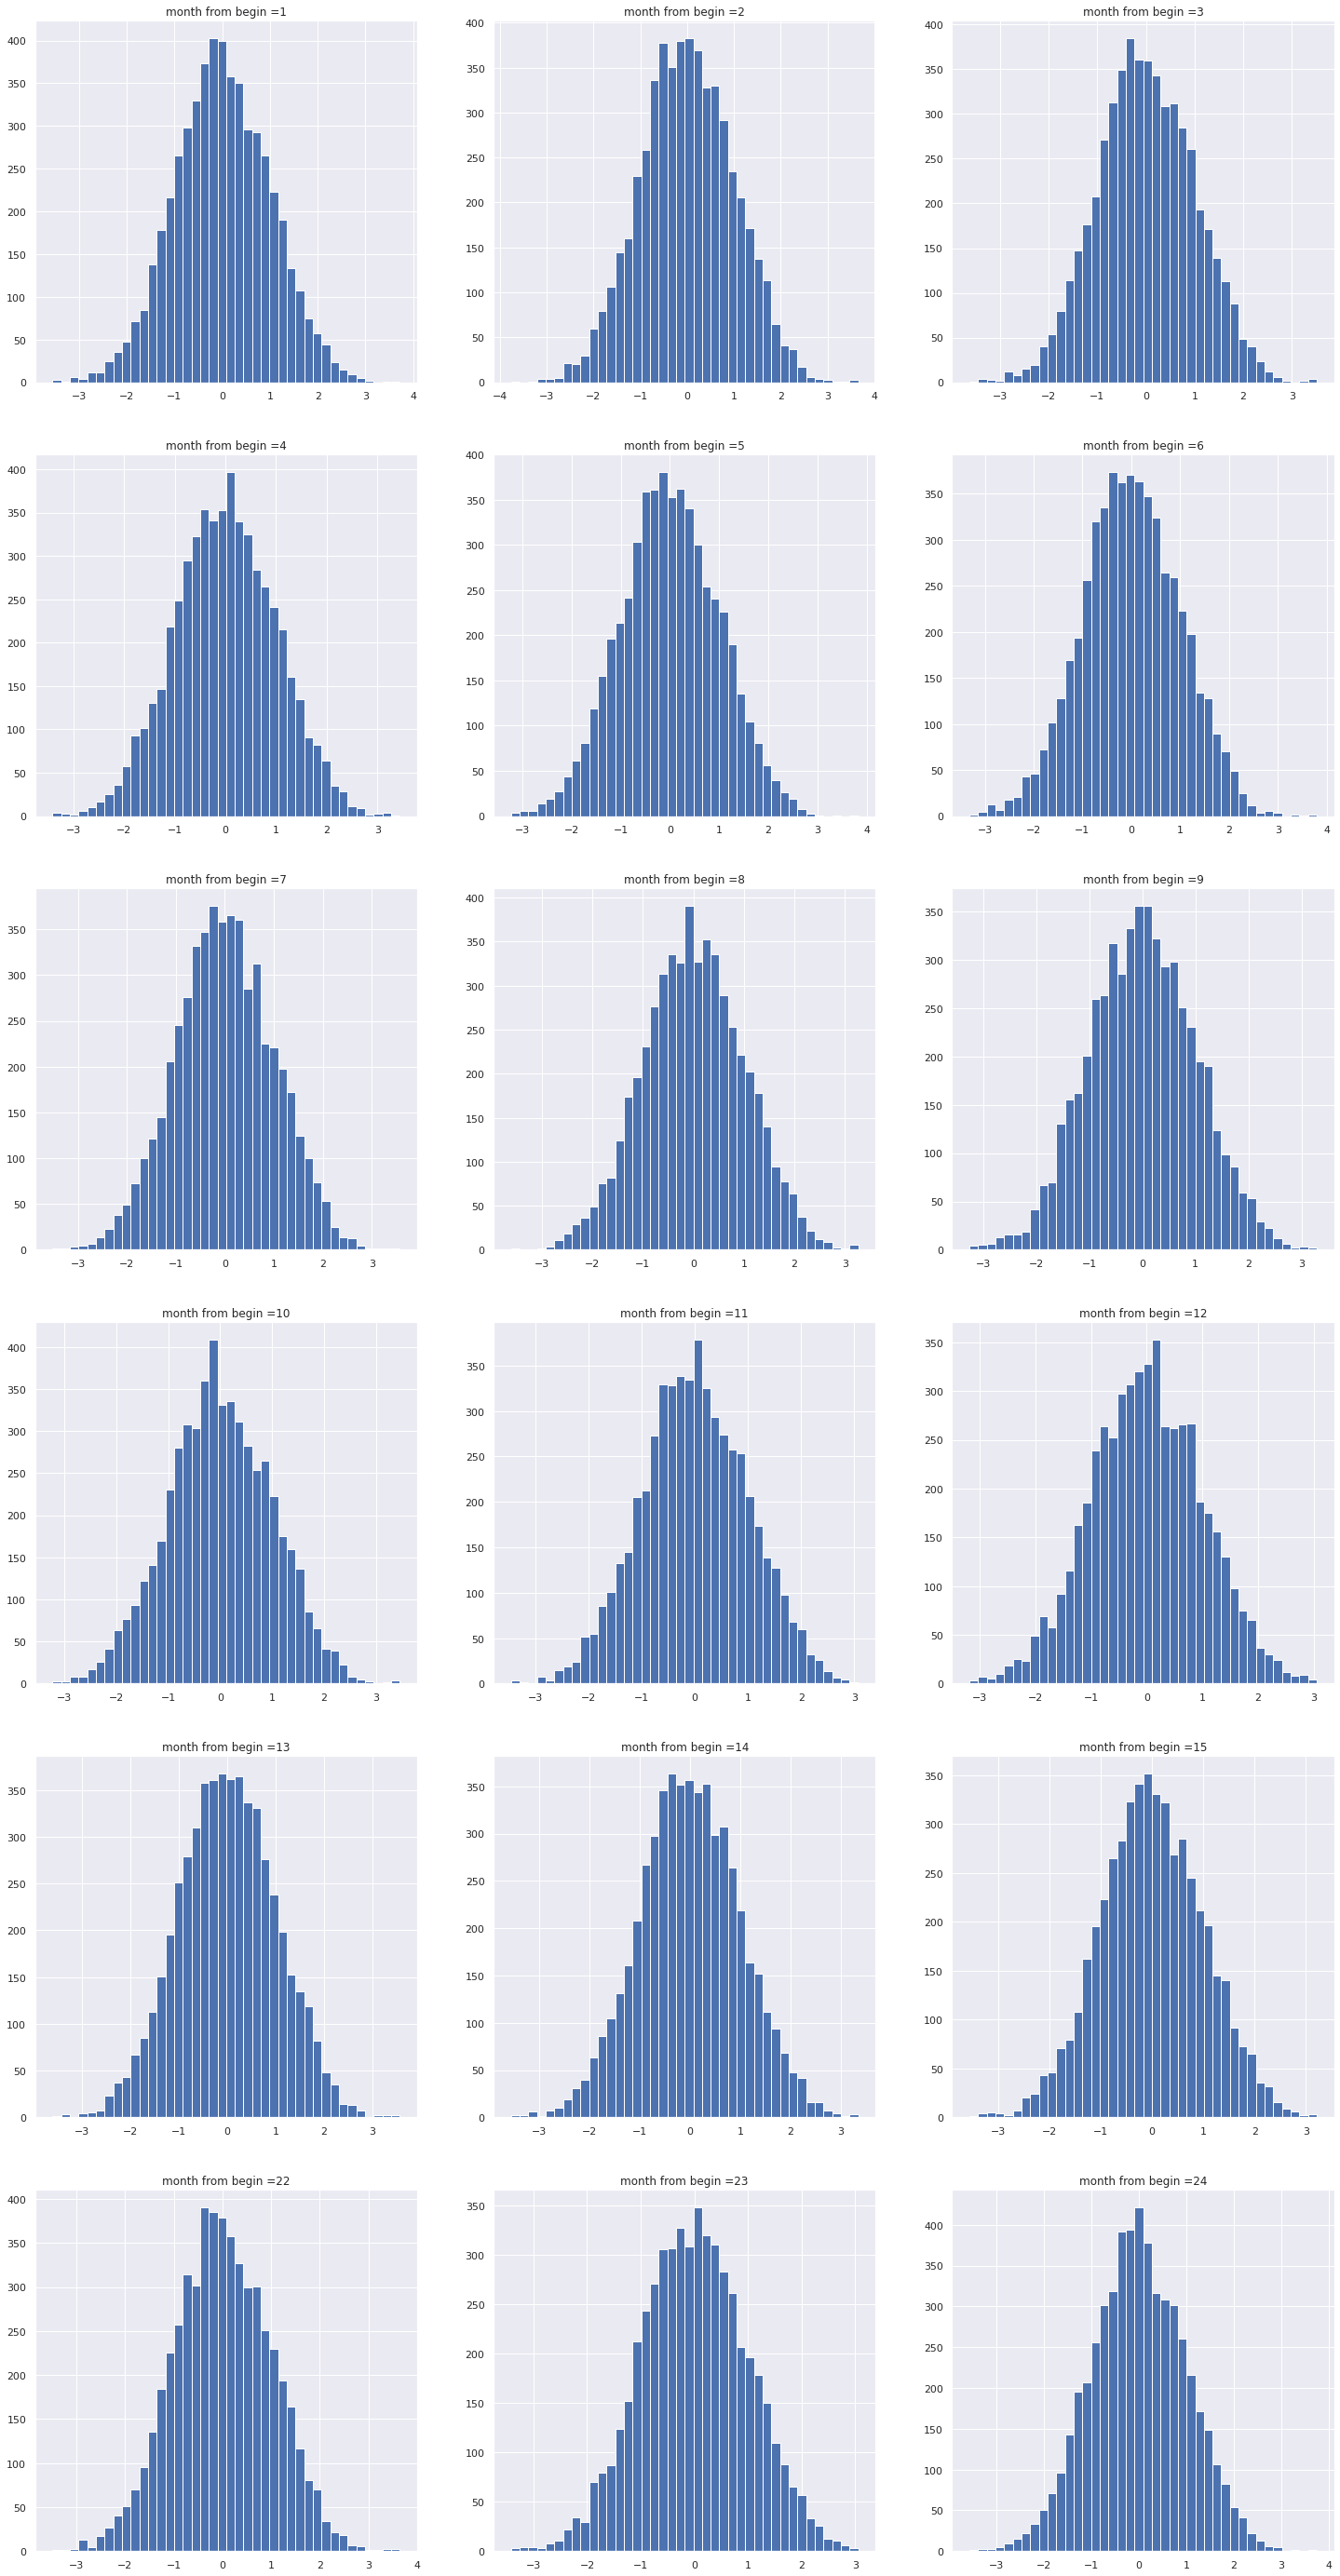

In [242]:
PW_street_data_array = []

y = df["mohth_from_begin"].values
df['normal_price_month_m2'] = 0.0

for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df["price_per_m2"][y == i].values.reshape(-1, 1))
    df["normal_price_month_m2"][y == i] =\
                                    PW.transform(df["price_per_m2"][y == i].values.reshape(-1, 1)).reshape(-1)
    PW_street_data_array.append(PW)
    
fig, ax = plt.subplots(6, 3, figsize=(25,50))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df["normal_price_month_m2"][y == month].values, bins=40)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

Картина обычная, аномалий нет

In [243]:
PW_street_array = []
y = df["street_id"].values
df['normal_price_street_m2'] = 0.0

for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df["price_per_m2"][y == i].values.reshape(-1, 1))
    df["normal_price_street_m2"][y == i] =\
                                    PW.transform(df["price_per_m2"][y == i].values.reshape(-1, 1)).reshape(-1)
    PW_street_array.append(PW)

Считаю среднюю и робастную среднюю оценки средней цены за квадратный метр.

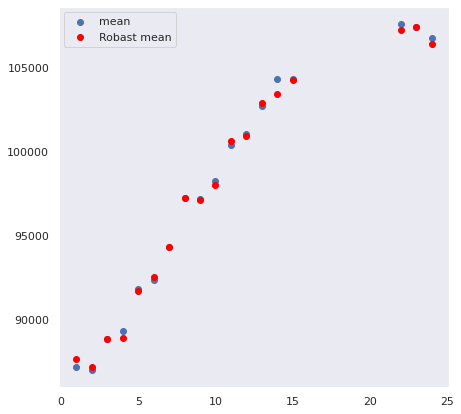

In [244]:
# Средняя оценка стоимости квадратного метра
mean_price_m2 = df[['price_per_m2', 'mohth_from_begin']].groupby(['mohth_from_begin']).mean()

# Вклад в стоимость, нет пропусков и уникальное значение стоимости - большой вклад
df['weight_price_m2'] = df["price_per_m2"] * df["weights"]

# Выбираем только квартиры с ценами в пределах -2-2 стандартных отклонений по месяцам
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2)

# Выбираем только квартиры с ценами в пределах -3 2 стандартных отклонений по улицам
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3)
mask = mask1 * mask2

robast_mean_price_m2 = df[['weight_price_m2', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum() /\
                        df[['weights', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum().values

plt.figure(figsize=(7,7))
plt.scatter(mean_price_m2.index, mean_price_m2.values, label = "mean")
plt.scatter(robast_mean_price_m2.index, robast_mean_price_m2.values, label = "Robast mean", color="red")
plt.grid()
plt.legend()
plt.show()

Также видна хорошая линейная зависимость. Решим регрессию, получим синтезированный признак в модель

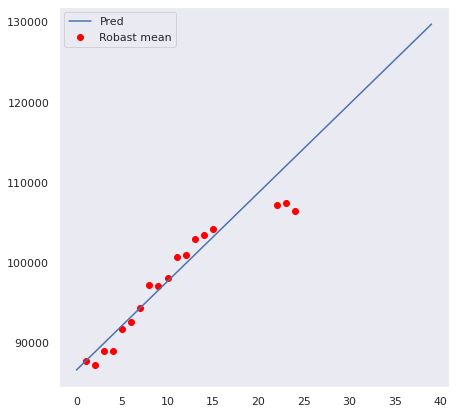

In [245]:
train = robast_mean_price_m2
linear_model = SVR(kernel='poly', degree=1, C=10000).fit(X=train.index.values.reshape(-1, 1), y=train.values)

pred = linear_model.predict(X=np.arange(0, 40).reshape(-1, 1))

plt.figure(figsize=(7,7))
plt.plot(np.arange(0, 40).reshape(-1, 1), pred, label="Pred")
plt.scatter(robast_mean_price_m2.index, robast_mean_price_m2.values, label="Robast mean", color="red")
plt.grid()
plt.legend()
plt.show()

In [246]:
time_24 = linear_model.predict([[24]])

# Прогноз средней цены
df['model_pred_mean_m2'] = linear_model.predict(df["mohth_from_begin"].values.reshape(-1, 1))

# Во сколько квартира лучше средней
df['model_coef_price_m2'] = df['price_per_m2'] / df['model_pred_mean_m2']

# Коэффициент стоимости от времени
df['model_time_coef_m2'] = df["model_pred_mean_m2"] / time_24
# Цена с поправкой на время
df['model_price_m2_without_time'] = df["price_per_m2"] / df["model_time_coef_m2"]

# Прогноз средней цены для теста
df_test['model_pred_mean_m2'] = linear_model.predict(df_test.mohth_from_begin.values.reshape(-1, 1))

# Опорным берется последний месяц
df_test['model_time_coef_m2'] = df_test["model_pred_mean_m2"] / time_24

## Data Clusterisation

Выполняю кластеризацию. По площади и стомости квадратного метра с поправкой на время.
Дополнительная фича для catboost.

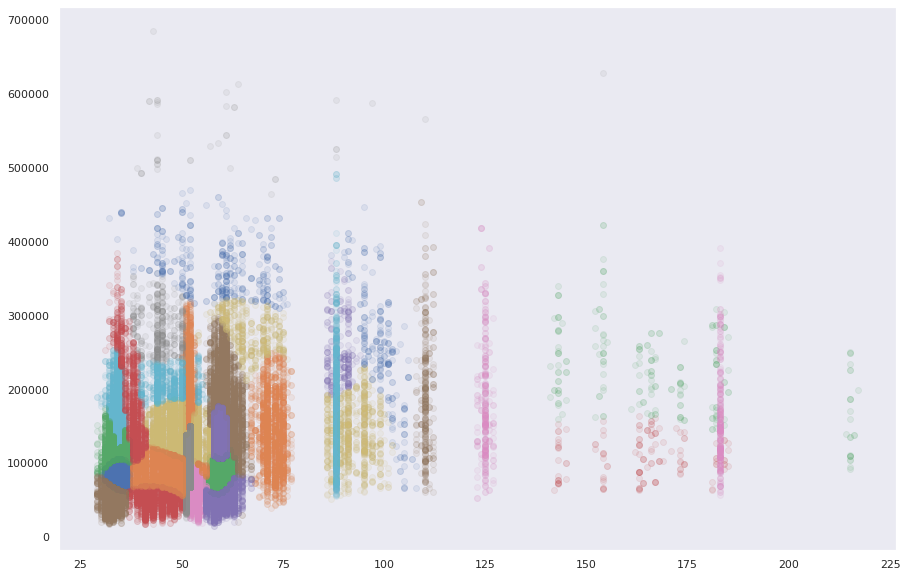

In [247]:
# Введем список цветов
colors_list = list(colors._colors_full_map.values())
train = df.sample(frac=0.8, replace=True, random_state=42, weights=df["weights"])

claster = ['model_price_m2_without_time', 'area']
# Количество кластеров заранее неизвестно, DBCSAN потребует подбор гиперпараметров, оттого воспользуемся
# простейшими гауссовскими кластеризаторами
classtering = Pipeline([
    ('SS', StandardScaler()),
    ('GaussianMixture', GaussianMixture(n_components=30, random_state=42, n_init = 10)) 
])

labels = classtering.fit_predict(train[claster])


plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(labels):
    plt.scatter(train["area"][i == labels].values,\
                train["model_price_m2_without_time"][i==labels].values, cmap=colors_list[i], alpha=0.1)
plt.show()

In [248]:
df['labels'] = classtering.predict(df[claster])
print(f"Итого получилось {len(pd.unique(df['labels']))} уникальных меток кластеров")

Итого получилось 30 уникальных меток кластеров


Попробуем предсказать метрики на датасете

In [249]:
train, valid = train_test_split(df, train_size=0.5)
features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist','n_photos', 
           'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

target = ['labels']

train_pool = Pool(train[features], label=train[target], weight = train["weights"].values)
valid_pool = Pool(valid[features], label=valid[target])

model = CatBoostClassifier(n_estimators=2000, random_state=42,
                           auto_class_weights='SqrtBalanced'
                           )

model.fit(train_pool, eval_set=valid_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [250]:
pred_train = model.predict(train_pool)
pred_valid = model.predict(valid_pool)

train['pred_labels'] = pred_train
valid['pred_labels'] = pred_valid

In [251]:
print("train: \n", classification_report(pred_train, train["labels"].values))
print("valid: \n", classification_report(pred_valid, valid["labels"].values))

train: 
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      3878
           1       0.63      0.75      0.69      1453
           2       0.68      0.69      0.68      5883
           3       1.00      1.00      1.00        83
           4       1.00      0.99      1.00       129
           5       1.00      1.00      1.00       190
           6       0.81      0.85      0.83      2051
           7       0.95      0.76      0.84       317
           8       0.61      0.77      0.68      1857
           9       0.75      0.67      0.71      2566
          10       0.98      0.95      0.96       205
          11       1.00      0.98      0.99      1304
          12       1.00      1.00      1.00       130
          13       0.79      0.71      0.75      2708
          14       0.64      0.63      0.63      2573
          15       0.66      0.72      0.69      2316
          16       1.00      1.00      1.00       129
          17      

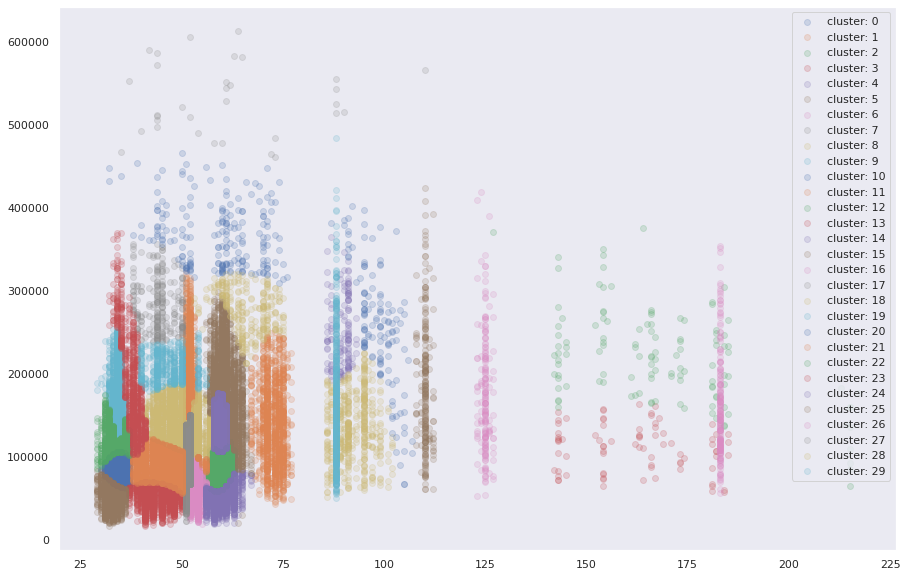

In [252]:
# Истинные метки
plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(train["pred_labels"].unique()):
    plt.scatter(valid["area"][i == valid["labels"]].values,
                valid["model_price_m2_without_time"][i==valid["labels"]].values,
                cmap=colors_list[i], alpha=0.2, label ='cluster: ' + str(i))
plt.legend()
plt.show()

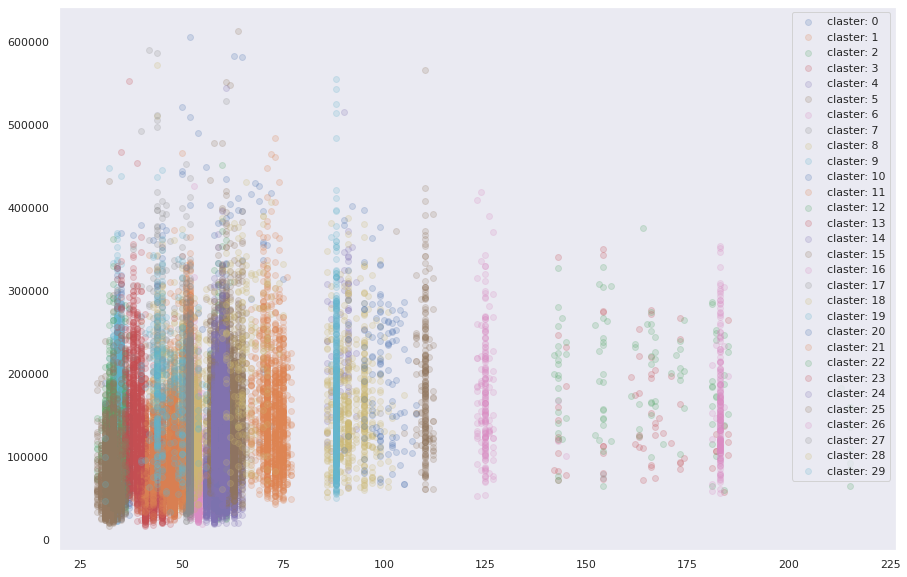

In [253]:
# Прогнозные
plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(valid.pred_labels.unique()):
    plt.scatter(valid["area"][i == valid["pred_labels"]].values, 
                valid["model_price_m2_without_time"][i==valid["pred_labels"]].values,
                cmap=colors_list[i], alpha=0.2, label ='claster: ' + str(i))
plt.legend()
plt.show()

Визуально качество разметки - неудовлетворительное. Попробуем обучится вместе с ним, в случае чего - уберем

In [254]:
df['labels'] = model.predict(df[features])
df_test['labels'] = model.predict(df_test[features])

## Valid Training
Теперь попробуем валидироваться на всей train выборке, проверим качество, используем все фичи

In [255]:
df_train = df[df['mohth_from_begin'].values < 20]
df_valid = df[df['mohth_from_begin'].values > 20]

labels = ['labels'] 
initial_features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist','n_photos', 
                   'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features_ = ['street_id']

target = ['model_price_without_time']

cat_features = cat_features_ + labels
features = initial_features + labels

train_pool = Pool(data = df_train[features], label = df_train[target], cat_features=cat_features)
valid_pool = Pool(data = df_valid[features], label = df_valid[target], cat_features=cat_features)

In [256]:
model = CatBoostRegressor(random_state=42, n_estimators=15000, loss_function='MAE', eval_metric='MAE',
                          bagging_temperature=0.43, depth=6, l2_leaf_reg=299, learning_rate=0.056)

model.fit(train_pool, eval_set=valid_pool, verbose=False, plot=True)

pred_train = model.predict(df_train[features])
pred_valid = model.predict(df_valid[features])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [257]:
dict(zip(model.feature_names_, model.feature_importances_))

{'street_id': 29.08831140850101,
 'build_tech': 6.842557025905713,
 'floor': 2.1102910723537387,
 'area': 32.38700935724537,
 'rooms': 2.789744238572498,
 'balcon': 0.2834124455318297,
 'metro_dist': 3.0004533992633573,
 'n_photos': 1.3384111927560751,
 'kw1': 0.22348696176696498,
 'kw2': 0.2093192780345997,
 'kw3': 0.02694654500432255,
 'kw4': 0.01221645749389654,
 'kw5': 0.029797231445316544,
 'kw6': 0.0069720599745229156,
 'kw7': 0.008251898828030466,
 'kw8': 0.013259724854538848,
 'kw9': 0.01964546036516361,
 'kw10': 0.03231095868578421,
 'kw11': 0.011207562735801245,
 'kw12': 0.03294085987530897,
 'kw13': 0.005744873520605166,
 'labels': 21.527709987285892}

Выясняется, что kw_1-kw_13 вообще не влияют на ценообразование.
А labels все-таки вносит вес

In [258]:
print("Mae for model_price without time")

print("train: ", mean_absolute_error(pred_train, df_train[target]))
print("valid: ", mean_absolute_error(pred_valid, df_valid[target]))

Mae for model_price without time
train:  418070.80926032073
valid:  450278.6517307744


In [259]:
print("Mae for result_price")
print("train: ", mean_absolute_error(pred_train * df_train["model_time_coef"], df_train["price"]))
print("valid: ", mean_absolute_error(pred_valid * df_valid["model_time_coef"], df_valid["price"])) 

Mae for result_price
train:  364936.21760867914
valid:  446576.50120784214


In [260]:
df_train['pred'] = pred_train
df_valid['pred'] = pred_valid

In [268]:
df_train['error'] = df_train["model_price_without_time"] - df_train["pred"]
df_train['abs_error'] = np.abs(df_train['error'])
df_valid['error'] = df_valid["model_price_without_time"] - df_valid["pred"]
df_valid['abs_error'] = np.abs(df_valid['error'])
df_train['fraction_error'] = df_train["abs_error"] / df_train["model_price_without_time"]
df_valid['fraction_error'] = df_valid["abs_error"] / df_valid["model_price_without_time"]

SyntaxError: invalid syntax (4049810227.py, line 5)

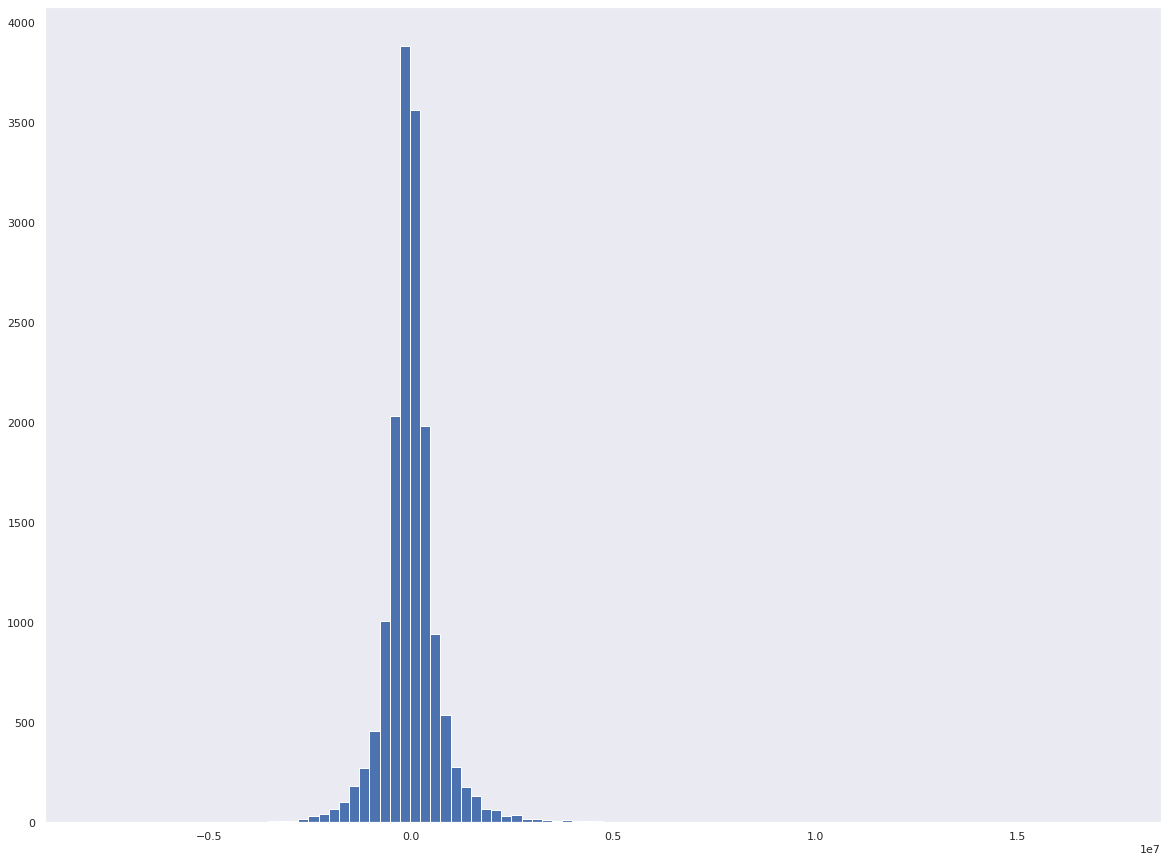

In [262]:
plt.figure(figsize=(20, 15))
plt.grid()
plt.hist(df_valid["error"].values, bins=100)
plt.show()

Ошибка слабо смещена

In [263]:
params = ['street_id', 'build_tech', 'floor', 'area','rooms', 'balcon', 'metro_dist', 'n_photos', 
          'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13',
          'mohth_from_begin', 'price',  'pred', 'error', 'abs_error', 'fraction_error']

df_train[params].sort_values(by='fraction_error', ascending=False).head(10)

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw10,kw11,kw12,kw13,mohth_from_begin,price,pred,error,abs_error,fraction_error
43320,388,1.0,2,60,3,0,25.000000,0,0,0,...,0,0,0,0,6,2818000,6.675519e+06,-3.385166e+06,3.385166e+06,1.028816
3963,227,1.0,1,60,3,0,20.000000,2,0,1,...,0,0,0,0,1,2890000,7.047773e+06,-3.508563e+06,3.508563e+06,0.991341
35204,179,1.0,5,35,1,0,20.000000,3,0,1,...,0,0,0,0,4,1229000,2.889185e+06,-1.426947e+06,1.426947e+06,0.975865
34770,564,0.0,3,47,2,0,18.525954,3,1,1,...,0,0,0,0,4,1705000,3.925772e+06,-1.897199e+06,1.897199e+06,0.935238
25104,622,1.0,2,60,3,0,25.000000,5,0,1,...,0,0,0,0,2,2852000,6.523026e+06,-3.064135e+06,3.064135e+06,0.885872
35081,651,1.0,3,60,3,0,10.000000,7,0,1,...,0,0,0,0,4,5185000,1.156516e+07,-5.396162e+06,5.396162e+06,0.874722
54151,483,1.0,1,60,3,0,25.000000,0,0,1,...,0,0,0,0,8,2616000,5.605050e+06,-2.606405e+06,2.606405e+06,0.869194
26841,415,1.0,4,35,1,0,20.000000,0,0,0,...,0,0,0,0,3,2289000,5.116443e+06,-2.366950e+06,2.366950e+06,0.860868
22144,210,1.0,3,60,3,0,30.000000,6,0,0,...,0,0,0,0,2,2540000,5.730376e+06,-2.649876e+06,2.649876e+06,0.860210
56343,584,1.0,5,60,3,0,25.000000,5,0,1,...,0,0,0,0,8,3284000,6.997553e+06,-3.233199e+06,3.233199e+06,0.858899


## Model hyperopts optimisation
Попробуем подобрать гиперпараметры модели, затем переобучимся и посмотрим качество на валидацинной выборке

In [264]:
space = {
        'n_estimators': hp.quniform('n_estimators', 5000, 15000, 1),
        'depth': hp.quniform("depth", 5, 9, 1),
        'learning_rate': hp.loguniform('learning_rate', -3.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 100, 300),
        'bagging_temperature': hp.uniform('bagging_temperature', 0.2, 1), 
       }
cur_loss = np.inf

In [265]:
def objective(params):
    model = catboost.CatBoostRegressor(
                                         iterations=params['n_estimators'], 
                                         learning_rate=params['learning_rate'],
                                         depth=int(params['depth']),
                                         l2_leaf_reg=params['l2_leaf_reg'],
                                         bagging_temperature=params['bagging_temperature'],
                                         loss_function='MAE',
                                         use_best_model=True,
                                         eval_metric='MAE'
                                       )

    model.fit(train_pool, eval_set = valid_pool, verbose = False)
    y_pred = model.predict(valid_pool) 
    loss = mean_absolute_error(valid_pool.get_label(), y_pred)
    print(loss)
    return {'loss':loss, 'status':STATUS_OK }

best = hyperopt.fmin(
                     fn=objective, 
                     space=space,
                     algo=tpe.suggest,
                     max_evals=20,
                     verbose=True,
                     )


459625.90064696496                                                              
454975.70745915646                                                              
457849.9331515455                                                               
452210.4009799232                                                               
466221.9722089609                                                               
453346.108102192                                                                
454005.3696697545                                                               
451463.4785169203                                                               
453160.8302480745                                                               
459755.371493113                                                                
452086.02904282475                                                              
460477.7911773051                                                               
463995.0842821349           

In [266]:
print(best)

{'bagging_temperature': 0.9264799340993537, 'depth': 6.0, 'l2_leaf_reg': 126.00992075575424, 'learning_rate': 0.09585215114866856, 'n_estimators': 11270.0}


## Final model learning

In [267]:
labels = ['labels'] 
initial_features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist','n_photos', 
                   'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features_ = ['street_id']

target = ['model_price_without_time']

cat_features = cat_features_ + labels
features = initial_features + labels

train_pool = Pool(data=df[features], label=df[target], cat_features=cat_features)

In [269]:
model = CatBoostRegressor(random_state=42, n_estimators=11500, loss_function='MAE', eval_metric='MAE',
                          bagging_temperature=0.926, depth=6, l2_leaf_reg=126, learning_rate=0.0958)

model.fit(train_pool, verbose=False, plot=True)

pred_train = model.predict(df_train[features])
pred_valid = model.predict(df_valid[features])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [270]:
dict(zip(model.feature_names_, model.feature_importances_))

{'street_id': 29.566818906240645,
 'build_tech': 5.780464406388623,
 'floor': 2.1519368025847303,
 'area': 27.948616673626496,
 'rooms': 4.099046121459257,
 'balcon': 0.20720781275751982,
 'metro_dist': 2.7841534355031383,
 'n_photos': 1.2531380219700383,
 'kw1': 0.28047057288268856,
 'kw2': 0.1697043305050115,
 'kw3': 0.035618363151456056,
 'kw4': 0.01582285886009544,
 'kw5': 0.02820596135136993,
 'kw6': 0.018003525071612816,
 'kw7': 0.007416508847462976,
 'kw8': 0.014845284685697546,
 'kw9': 0.017097923060497847,
 'kw10': 0.029945516688628427,
 'kw11': 0.03647132552504735,
 'kw12': 0.0545962178816234,
 'kw13': 0.018080776390823824,
 'labels': 25.48233865456745}

In [271]:
df_test['result_price'] = model.predict(df_test[features])  * df_test["model_time_coef"]
df_test['result_price']

0        7.099613e+06
1        3.823996e+06
2        3.098649e+06
3        2.794175e+06
4        6.206265e+06
             ...     
99995    1.973699e+06
99996    6.304737e+06
99997    4.377416e+06
99998    3.328987e+06
99999    4.759955e+06
Name: result_price, Length: 100000, dtype: float64

In [273]:
sub = pd.read_csv('https://raw.githubusercontent.com/Totenkaf/ML_Homeworks/main/HW_4/data/sign_classes.csv')
sub = pd.read_csv('data/SampleSubmission.csv')
sub.price = df_test["result_price"]
sub.to_csv("submit_catboost.csv", index = False)

## Conclusion
Работа CatBoost с оптимизацией параметров хорошо показала себя на валидационной выборке.  
На Kaggle результаты оказались хуже ожидаемых.

Ссылка на сабмит [здесь](https://www.kaggle.com/competitions/spring-2022-property-prices/leaderboard)
Полученный лучший score = 700241.74465 (MAE метрика)